# Theory for $\delta T(x)$ accounting for changes in WTG and CE
This extends the $\delta h(x) = \delta \overline{h}$ theory for the tropics with an additional term accounting for the fact that the current climate differs from convective equilibrium (CE) and constant free troposphere temperature gradient (WTG). 

It also quantifies the effect of changes to these two terms with warming.

In [2]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat
from isca_tools.utils.constants import kappa, L_v, c_p, g, R
from isca_tools.utils import area_weighting
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.aquaplanet_theory import get_delta_temp_quant_theory, get_gamma
from isca_tools.utils.stats import z_score_from_confidence_interval
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import integrate
import numpy_indexed
from scipy.stats import percentileofscore
import copy
from sklearn.linear_model import TheilSenRegressor
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')

2024-04-05 12:09:38,326 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


In [3]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'sphum', 'height', 'klzbs', 'convflag']        # only keep variables required to compute relative humidity and MSE
# Load dataset
tau_lw_ref = 0.6
tau_lw_warm = 1
exp_dir = 'tau_sweep/aquaplanet/depth=1/'
exp_names = [f"k={str(tau_lw_ref).replace('.','_')}", f"k={str(tau_lw_warm).replace('.','_')}"]
n_exp = len(exp_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []
for i in range(n_exp):
    ds_use = isca_tools.load_dataset(exp_dir + exp_names[i])[var_keep]
    ds += [ds_use]      # only keep the surface values
    namelist = isca_tools.load_namelist(exp_dir + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]

## Get datasets
Get one surface dataset for summer for each $\kappa$, combining all latitudes: `ds_all`. This combines the summer months in each hemisphere, e.g. negative latitudes will only correspond to times in December, January or February.


In [4]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [5]:
# Compute Global Average Surface Temperature and get near surface temperature data
# Use all data after 2 years, as clearly converged from the above spin up plot
use_time_start = 360*2
pressure_ft = 500           # Desired approximate pressure of free troposphere (hPa)

# Chose whether to only consider summer days or consider all days
season = 'all'
# season = 'summer'
# season = 'winter'
if season == 'summer':
    season_months = {'nh': [6, 7, 8], 'sh': [12, 1, 2]}   # JJA for NH and DJF for SH
elif season == 'winter':
    season_months = {'nh': [12, 1, 2], 'sh': [6, 7, 8]}   # JJA for NH and DJF for SH

# Tropics
region = 'tropics'
lat_min = 0
lat_max = 20
# Extratropics
# region = 'extratropics'
# lat_min = 40
# lat_max = 65
# Poles
# region = 'High Latitudes'
# lat_min = 70
# lat_max = 90
# region = 'Global'
# lat_min = 0
# lat_max = 90

ds_all = []
with tqdm(total=n_exp, position=0, leave=True) as pbar:
    for i in range(n_exp):
        ds_use = ds[i].sel(time=slice(use_time_start, np.inf))
        ds_use = ds_use.sel(pfull=[np.inf, pressure_ft], method='nearest')      # only keep the surface values - get rid of pfull coordinate
        ds_use = ds_use.where((np.abs(ds_use.lat) <= lat_max) & (np.abs(ds_use.lat) >= lat_min), drop=True)

        if season == 'summer' or season == 'winter':
            # Only consider summer as has expected circulation
            ds_nh_summer = isca_tools.utils.annual_time_slice(ds_use, season_months['nh']).sel(lat=slice(lat_min, lat_max)) 
            ds_sh_summer = isca_tools.utils.annual_time_slice(ds_use, season_months['sh']).sel(lat=slice(-lat_max, -lat_min))  
            # Combine hemispheres and average over longitude, time and latitude.
            # Note that April, May, June, October, November and December will not be included in this dataset
            ds_use = xr.concat([ds_sh_summer, ds_nh_summer], dim='lat')
        ds_use = ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))
        ds_all += [ds_use.load()]
        pbar.update(1)

ind_surf = 0
ind_ft = 1
p_surface = float(ds_all[0].pfull[ind_surf]) * 100
pressure_ft_actual = float(ds_all[0].pfull[ind_ft]) * 100       # Actual pressure of free troposphere (Pa)

100%|██████████| 2/2 [00:20<00:00, 10.41s/it]


## Near Surface Temperature Quantile
Get variables as a function of near-surface temperature quantile

In [7]:
quantiles_all = np.arange(1, 100)
percentile_label = 'Temperature percentile, $x$'
n_quant_all = len(quantiles_all)
n_lat = len(ds_all[0].lat)
n_pressure = ds_all[0].pfull.shape[0]
lat_weights = np.cos(np.deg2rad(ds_all[0].lat))     # latitude area weighting is just the cosine

# Days must have klzb < thresh and convflag > thresh to be considered convecting.
klzb_thresh = 13
convflag_thresh = 1

temp_mean = np.zeros((n_exp, n_pressure, n_lat))         # second index: 0 is surface, 1 is free trop
mse_mod_mean = np.zeros((n_exp, n_lat))
sphum_mean = np.zeros((n_exp, n_lat))
z_mean = np.zeros((n_exp, n_pressure, n_lat))

lnp_const = R * np.log(p_surface/pressure_ft_actual)/2      # for modified MSE calculation
# as function of temperature quantile
temp_quant3 = np.zeros((n_exp, n_pressure, n_lat, n_quant_all))
mse_mod_quant3 = np.zeros((n_exp, n_lat, n_quant_all))
sphum_quant3 = np.zeros((n_exp, n_lat, n_quant_all))
z_quant3 = np.zeros((n_exp, n_pressure, n_lat, n_quant_all))
convflag_quant3 = np.zeros((n_exp, n_lat, n_quant_all))
klzbs_quant3 = np.zeros((n_exp, n_lat, n_quant_all))
convfract_quant3 = np.zeros((n_exp, n_lat, n_quant_all))            # record fraction of days convecting

with tqdm(total=n_exp*n_lat*n_quant_all, position=0, leave=True) as pbar:
    for i in range(n_exp):
        temp_mean[i] = ds_all[i].temp.mean(dim='lon_time')
        sphum_mean[i] = ds_all[i].sphum.isel(pfull=ind_surf).mean(dim='lon_time')
        z_mean[i] = ds_all[i].height.mean(dim='lon_time')
        # Modify MSE so is one used to compute adiabatic temperature
        mse_mod = moist_static_energy(ds_all[i].temp[ind_surf], ds_all[i].sphum[ind_surf], height=0, c_p_const=c_p - lnp_const)
        mse_mod_mean[i] = mse_mod.mean(dim='lon_time')
        if 'convflag' in var_keep:
            is_convecting = np.logical_and(ds_all[i].klzbs<klzb_thresh, ds_all[i].convflag > convflag_thresh)
        for k in range(n_lat):
            for j, quant in enumerate(quantiles_all):
                use_ind = get_quant_ind(ds_all[i].temp.isel(pfull=ind_surf)[k], quant, 0.5, 0.5)
                sphum_quant3[i, k, j] = ds_all[i].sphum.isel(pfull=ind_surf)[k, use_ind].mean()
                z_quant3[i, :, k, j] = ds_all[i].height[:, k, use_ind].mean(dim='lon_time')
                mse_mod_quant3[i, k, j] = mse_mod[k, use_ind].mean(dim='lon_time')
                temp_quant3[i, :, k, j] = ds_all[i].temp[:, k, use_ind].mean(dim='lon_time')
                if 'convflag' in var_keep:
                    convflag_quant3[i, k, j] = ds_all[i].convflag[k, use_ind].mean(dim='lon_time')
                    klzbs_quant3[i, k, j] = ds_all[i].klzbs[k, use_ind].mean(dim='lon_time')
                    convfract_quant3[i, k, j] = np.sum(is_convecting[k, use_ind])/is_convecting[k, use_ind].size
                pbar.update(1)

100%|██████████| 2772/2772 [00:26<00:00, 103.96it/s]


## Relating $z_{FT}$ to $T_{500}$ and $T_s$
A crucial aspect to this theory is relating the geopotential height $z_{FT}$ to near-surface temperature $T$ and free troposphere temperature $T_{FT}$.

We start with two equations, from Zhang 2023. The first combines hydrostatic balance and the ideal gas law. The second assumes a constant lapse rate, $\Gamma$, for integration processes.

$d\ln p = -\frac{g}{RT(p)}dz$;      $z(p) - z_s = \frac{T_s - T(p)}{\Gamma}$

Combining the two, we get $d\ln p = \frac{g}{R\Gamma}d\ln T$.

Integrating between the free troposphere at 500hPa and surface at 1000hPa, we get:
$\ln(\frac{1000}{500}) = \ln 2 = \frac{g}{R\Gamma}\ln(\frac{T_s}{T_{500}})$ or $\frac{1}{\Gamma} = \frac{R\ln 2}{g\ln(\frac{T_s}{T_{500}})}$

We also have the $z$ equation applied at 500hPa: $z_{500} - z_s = \frac{T_s - T_{500}}{\Gamma}$. Combining the two, we get:
$z_{500} - z_s \approx \frac{R\ln 2(T_s - T_{500})}{g\ln(\frac{T_s}{T_{500}})}$

We can re-write the denominator in $\ln(1+x)$ form as $\ln(1+\frac{T_s-T_{500}}{T_{500}})$. Here $x=\frac{T_s-T_{500}}{T_{500}}$ and is small. Max value in tropics is about 0.15. 

The taylor series is $\frac{1}{\ln(1+x)} \approx \frac{1}{x} + \frac{1}{2} - \frac{x}{12} + ...$. Because $x$ is small, I propose keeping just the first two terms. In which case, we get:

$z_{500} - z_s \approx \frac{R\ln 2(T_s - T_{500})}{g}(\frac{T_{500}}{T_s-T_{500}} + \frac{1}{2}) = \frac{R\ln 2}{2g}(T_s + T_{500})$

The plots below shows that the taylor approximation is pretty accurate, and they are both decent approximations for the actual geopotential height.

In [8]:
def get_z_theory(temp_surf, temp_ft, taylor=True, pressure_surf=p_surface, pressure_ft=pressure_ft_actual):
    lnp_prefactor = R * np.log(pressure_surf/pressure_ft) / g
    if taylor:
        return lnp_prefactor/2 * (temp_surf + temp_ft)
    else:
        return lnp_prefactor * (temp_surf - temp_ft) / np.log(temp_surf/temp_ft)

z_theory_quant3 = {key: np.zeros((n_exp, n_lat, n_quant_all)) for key in ['full', 'taylor']}
z_theory_mean = {key: np.zeros((n_exp, n_lat)) for key in ['full', 'taylor']}
for i in range(n_exp):
    for key in z_theory_quant3:
        z_theory_quant3[key][i] = get_z_theory(temp_quant3[i, ind_surf], temp_quant3[i, ind_ft], True if key=='taylor' else False)
        z_theory_mean[key][i] = get_z_theory(temp_mean[i, ind_surf], temp_mean[i, ind_ft], True if key=='taylor' else False)

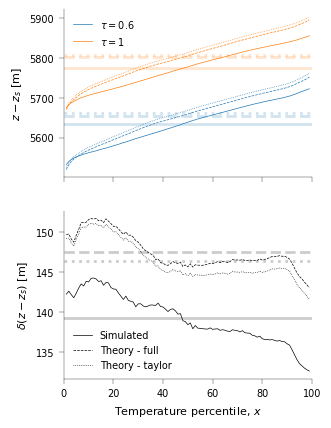

In [9]:
save_z_ft_fig = False
fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 2*width['one_col']/ar), sharex=True)
linestyles_use = {'full': '--', 'taylor': ':'}
for i in range(n_exp):
    ax[0].plot(quantiles_all, 
               np.average(z_quant3[i, ind_ft] - z_quant3[i, ind_surf], axis=0, weights=lat_weights), color=default_colors[i],
               label=f'$\\tau={tau_lw[i]}$')
    ax[0].axhline(np.average(z_mean[i, ind_ft]-z_mean[i, ind_surf], axis=0, weights=lat_weights), color=default_colors[i], lw=2, alpha=0.2)
    for key in z_theory_quant3:
        ax[0].plot(quantiles_all, 
                   np.average(z_theory_quant3[key][i], axis=0, weights=lat_weights), color=default_colors[i], 
                   linestyle=linestyles_use[key])
        ax[0].axhline(np.average(z_theory_mean[key][i], axis=0, weights=lat_weights), color=default_colors[i], 
                      linestyle=linestyles_use[key], lw=2, alpha=0.2)
ax[1].plot(quantiles_all, 
           np.average(np.diff(z_quant3[:, ind_ft] - z_quant3[:, ind_surf], axis=0)[0], axis=0, weights=lat_weights), color='k',
           label='Simulated')
ax[1].axhline(np.average(np.diff(z_mean[:, ind_ft]-z_mean[:, ind_surf], axis=0)[0], axis=0, weights=lat_weights), 
              color='k', lw=2, alpha=0.2)
for key in z_theory_quant3:
    ax[1].plot(quantiles_all, 
                   np.average(z_theory_quant3[key][1]-z_theory_quant3[key][0], axis=0, weights=lat_weights), 
               color='k', linestyle=linestyles_use[key], label=f'Theory - {key}')
    ax[1].axhline(np.average(z_theory_mean[key][1]-z_theory_mean[key][0], axis=0, weights=lat_weights), color='k', 
                  linestyle=linestyles_use[key], lw=2, alpha=0.2)
ax[0].legend()
ax[1].legend()
ax[0].set_ylabel('$z-z_s$ [m]')
ax[1].set_ylabel('$\delta (z-z_s)$ [m]')
ax[1].set_xlabel(percentile_label)
ax[0].set_xlim(0, 100)
if save_fig or save_z_ft_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/z_ft_approx_{region}_{season}.pdf",
                                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

## Adiabatic Temperature

The starting point for the original theory is the assumption that $\delta h(x) \approx \delta \overline{h}$.

We can define an adiabatic temperature, $T_{A, 500}$, such that the saturated free troposphere MSE is equal to the near-surface MSE:
$h(x) = c_pT_s + L_v q + g z_s = c_p T_{A, 500} + L_vq^*(T_{A, 500}) + gz_{A, 500}$.

Using the above approximation, we can sub in for $z_{A,500} - z_s \approx \frac{R\ln 2}{2g}(T_s + T_{A, 500})$ to get:
$h^{\dagger} = (c_p - \frac{R\ln 2}{2})T_s + L_v q = (c_p + \frac{R\ln 2}{2})T_{A, 500} + L_vq^*(T_{A, 500})$ 

Similarly, in the mean we have $\overline{h^{\dagger}} = (c_p + \frac{R\ln 2}{2})\overline{T_{A, 500}} + L_vq^*(\overline{T_{A, 500}})$

Where we have defined the modified moist static energy, $h^{\dagger} = h - \frac{R\ln 2}{2}T - gz$

Below, we solve these two equations to get estimates of $T_A(x)$ and $\overline{T_A}$ (dropping the 500hPa indicator).

The figure below is just a sanity check to ensure the equality of the two moist static energy like quantities. It also shows that $T_A$ differs from the actual free troposphere temperature. The different colours refer to the different simulations as usual.

In [10]:
def temp_adiabat_fit_func(temp_ft, mse_mod_surf, pressure_ft=pressure_ft_actual):
    # Adiabatic FT temperature is such that surf mod MSE equals free trop mod MSE
    return moist_static_energy(temp_ft, sphum_sat(temp_ft, pressure_ft), height=0, c_p_const=c_p + lnp_const) - mse_mod_surf

In [11]:
temp_adiabat_mean = np.zeros((n_exp, n_lat))
temp_adiabat_quant3 = np.zeros((n_exp, n_lat, n_quant_all))
for i in range(n_exp):
    for j in range(n_lat):
        temp_adiabat_mean[i, j] = scipy.optimize.fsolve(temp_adiabat_fit_func, 273, 
                                                                            args=(mse_mod_mean[i, j]))
        for k in range(n_quant_all):
            # MAYBE SHOULD COMPUTE THIS WITH kappa_quant. CHECK IF MAKES A DIFFERENCE!!
            temp_adiabat_quant3[i, j, k] = scipy.optimize.fsolve(temp_adiabat_fit_func, 273, 
                                                                            args=(mse_mod_quant3[i, j, k]))

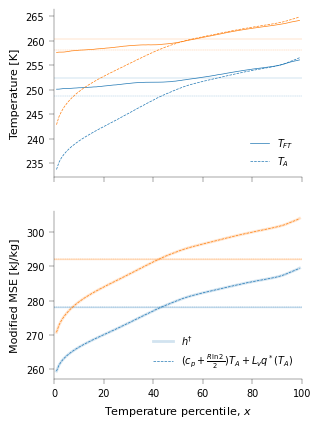

In [35]:
save_mse_ft_fig = False
mse_ft_sat_quant3 = {key: np.zeros((n_exp, n_lat, n_quant_all)) for key in ['kappa_x', 'kappa_mean', 'temp_adiabat']}
fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 2*width['one_col']/ar), sharex=True)
for i in range(n_exp):
    ax[0].plot(quantiles_all, 
            np.average(temp_quant3[i, ind_ft], axis=0, weights=lat_weights), color=default_colors[i], label='$T_{FT}$' if i==0 else None)
    ax[0].plot(quantiles_all, 
            np.average(temp_adiabat_quant3[i], axis=0, weights=lat_weights), color=default_colors[i], linestyle='--', 
               label='$T_A$' if i==0 else None)
    ax[0].axhline(np.average(temp_mean[i, ind_ft], axis=0, weights=lat_weights), color=default_colors[i], lw=ax_linewidth, alpha=0.6)
    ax[0].axhline(np.average(temp_adiabat_mean[i], axis=0, weights=lat_weights), color=default_colors[i], lw=ax_linewidth, alpha=0.6,
                  linestyle='--')
    ax[1].plot(quantiles_all, np.average(mse_mod_quant3[i], axis=0, weights=lat_weights), color=default_colors[i], 
               lw=2, alpha=0.2, label='$h^{\dagger}$' if i==0 else None)
    ax[1].plot(quantiles_all, np.average(moist_static_energy(temp_adiabat_quant3[i], sphum_sat(temp_adiabat_quant3[i], pressure_ft_actual),
                                                             height=0, c_p_const=c_p + lnp_const), axis=0, weights=lat_weights),
               color=default_colors[i], linestyle='--', label='$(c_p + \\frac{R\ln 2}{2})T_{A} + L_vq^*(T_{A})$' if i==0 else None)
    ax[1].axhline(np.average(mse_mod_mean[i], axis=0, weights=lat_weights), color=default_colors[i], 
               lw=1, alpha=0.2)
    ax[1].axhline(np.average(moist_static_energy(temp_adiabat_mean[i], sphum_sat(temp_adiabat_mean[i], pressure_ft_actual),
                                                 height=0, c_p_const=c_p + lnp_const), axis=0, weights=lat_weights), 
                  color=default_colors[i], linestyle='--', lw=ax_linewidth)
ax[0].legend()
ax[1].legend()
ax[0].set_ylabel('Temperature [K]')
ax[1].set_ylabel('Modified MSE [kJ/kg]')
ax[1].set_xlabel(percentile_label)
ax[0].set_xlim(0, 100)
if save_fig or save_mse_ft_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/mse_ft_sat_{region}_{season}.pdf",
                                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

## Extended Theory
Doing a taylor expansion of $h^{\dagger}(x)$ for a given simulation about $\overline{T_A}$ we get:
$h^{\dagger}(x) \approx (c_p+\frac{R\ln 2}{2}) \overline{T_A} + L_v q^*(\overline{T_A}) + (c_p + \frac{R\ln 2}{2} + L_v \alpha(\overline{T_A}) q^*(\overline{T_A}))\Delta T_A$

Using the definition of $\overline{h^{\dagger}}$, this becomes:
$h^{\dagger}(x)-\overline{h^{\dagger}} \approx (c_p + \frac{R\ln 2}{2} + L_v \alpha q^*)\Delta T_A$

This is shown by the dashed lines in the top plot of the second figure below. The dotted lines include the squared term in the expansion.

Taking the difference between simulations:
$\delta (h^{\dagger}(x)-\overline{h^{\dagger}}) \approx \beta_1 \delta \Delta T_A + \beta_2\frac{\Delta T_A}{\overline{T_A}}\delta \overline{T_A}$
where $\beta_1 = \frac{d\overline{h^{\dagger}}}{d\overline{T_A}} = c_p + \frac{R\ln 2}{2} + L_v \alpha q^*$ and $\beta_2 = \overline{T_A}\frac{d\beta_1}{d\overline{T_A}} = L_v \alpha q^*(\alpha \overline{T_A} - 2)$

From the equation for $\overline{h^{\dagger}}$, we have $\delta \overline{T_A} \approx \frac{\delta \overline{h^{\dagger}}}{\beta_1}$. This is shown in the first plot below with the exact $\delta \overline{h^{\dagger}}$.

Combining everything, we have:
$$\delta (h^{\dagger}(x)-\overline{h^{\dagger}}) \approx \beta_1 \delta \Delta T_A + \frac{\beta_2}{\beta_1}\frac{\Delta T_A}{\overline{T_A}}\delta \overline{h^{\dagger}}$$

This is shown by the thick red line in the bottom plot of the second figure below. The dotted red line includes squared terms in this equation. The black lines show just take the difference of the respective coloured lines in the plot above. The red dashed line should be the same as the red thick line - same equation used by different functions, really just a sanity check.

In [46]:
def get_h_anom_theory(temp_adiabat_mean, temp_adiabat_quant, p_ft = pressure_ft_actual,
                      include_squared_term=False):
    """
        Get h - h_mean theory using taylor expansion and free troposphere adiabatic temperatures.
    Args:
        temp_adiabat_mean: float
        temp_adiabat_quant: [n_quant]
        p_ft: float
        include_squared_term: bool

    Returns:
        [n_quant]
            MSE anomaly in kJ/kg
    """
    temp_adiabat_anom = temp_adiabat_quant - temp_adiabat_mean
    alpha_mean = clausius_clapeyron_factor(temp_adiabat_mean, p_ft)
    q_sat_mean = sphum_sat(temp_adiabat_mean, p_ft)
    if include_squared_term:
        squared_term = 0.5 * L_v * alpha_mean * q_sat_mean / temp_adiabat_mean * (alpha_mean * temp_adiabat_mean - 2) * temp_adiabat_anom**2
    else:
        squared_term = 0
    return ((c_p + lnp_const) * temp_adiabat_anom + L_v * q_sat_mean * alpha_mean * temp_adiabat_anom + squared_term)/1000

def get_delta_temp_adiabat_mean_theory(temp_adiabat_mean, mse_surf_mean, 
                                       temp_surf_mean = None, sphum_surf_mean = None, p_ft=pressure_ft_actual, p_surface=p_surface):
    """
    Assumes n_exp=2
    Args:
        temp_adiabat_mean: [n_exp]
        kappa_mean: [n_exp]
        mse_surf_mean: [n_exp]
            In units of kJ/kg
            If given, computes the exact difference in MSE surface. Otherwise, does linear expansion with temp_surf and sphum_surf.
        temp_surf_mean: [n_exp]
        sphum_surf_mean: [n_exp]
        p_ft: float (Pa)
        p_surface: float (Pa)

    Returns:
        float
    """
    if mse_surf_mean is not None:
        delta_mse = (mse_surf_mean[1] - mse_surf_mean[0]) * 1000        # convert into units of J/kg
    else:
        # Do linear taylor expansion to compute delta_mse if actual value not given
        delta_rh = float(np.diff(sphum_surf_mean / sphum_sat(temp_surf_mean, p_surface)))
        delta_temp_surf = temp_surf_mean[1] - temp_surf_mean[0]
        alpha_surf = clausius_clapeyron_factor(temp_surf_mean[0], p_surface)
        q_sat_surf = sphum_sat(temp_surf_mean[0], p_surface)
        delta_mse = (c_p + L_v * sphum_surf_mean[0] * alpha_surf) * delta_temp_surf + L_v * q_sat_surf * delta_rh
    alpha = clausius_clapeyron_factor(temp_adiabat_mean[0], p_ft)
    q_sat = sphum_sat(temp_adiabat_mean[0], p_ft)
    return delta_mse/ (c_p + lnp_const + L_v * alpha * q_sat)

def get_delta_h_anom_theory(temp_adiabat_mean, temp_adiabat_quant, delta_temp_adiabat_mean,
                            include_squared_term=False, p_ft=pressure_ft_actual):
    """
    
    Args:
        temp_adiabat_mean: [n_exp]
        temp_adiabat_quant: [n_exp, n_quant]
        delta_temp_adiabat_mean: float
        include_squared_term: bool
        p_ft: float

    Returns:
        [n_quant]
    """
    temp_anom = temp_adiabat_quant - temp_adiabat_mean[:, np.newaxis]
    delta_temp_anom = temp_anom[1] - temp_anom[0]
    q_sat = sphum_sat(temp_adiabat_mean[0], p_ft)
    alpha = clausius_clapeyron_factor(temp_adiabat_mean[0], p_ft)
    
    temp_anom_prefactor = c_p + lnp_const + L_v * q_sat * alpha
    temp_mean_prefactor = L_v * q_sat * alpha / temp_adiabat_mean[0] * (temp_adiabat_mean[0] * alpha - 2) * temp_anom[0]
    if include_squared_term:
        temp_anom_squared_prefactor = 0.5 * L_v * q_sat * alpha / temp_adiabat_mean[0] * (temp_adiabat_mean[0] * alpha - 2)
        temp_anom_prefactor = temp_anom_prefactor + 2 * temp_anom_squared_prefactor * temp_anom[0]
        temp_mean_squared_prefactor = 0.5 * L_v * q_sat * alpha / temp_adiabat_mean[0]**2 * (
                alpha**2 * temp_adiabat_mean[0]**2 - 6 * alpha * temp_adiabat_mean[0] + 6) * temp_anom[0]  # only include one term
        temp_mean_prefactor = temp_mean_prefactor + temp_mean_squared_prefactor * temp_anom[0]
        non_linear_prefactor = temp_mean_prefactor / temp_anom[0]
    else:
        temp_anom_squared_prefactor = 0
        temp_mean_squared_prefactor = 0
        non_linear_prefactor = 0
        
    # Convert into units of kJ/kg
    temp_anom_prefactor = temp_anom_prefactor/1000
    temp_anom_squared_prefactor = temp_anom_squared_prefactor/1000
    temp_mean_prefactor = temp_mean_prefactor/1000
    temp_mean_squared_prefactor = temp_mean_squared_prefactor/1000
    non_linear_prefactor = non_linear_prefactor/1000
    full_answer = temp_anom_prefactor * delta_temp_anom + temp_anom_squared_prefactor * delta_temp_anom**2 + \
                  temp_mean_prefactor * delta_temp_adiabat_mean + temp_mean_squared_prefactor * delta_temp_adiabat_mean**2 + \
                  non_linear_prefactor * delta_temp_anom * delta_temp_adiabat_mean
    info_dict = {'temp_anom': [temp_anom_prefactor, delta_temp_anom], 
                 'temp_anom_squared': [temp_anom_squared_prefactor, delta_temp_anom**2],
                 'temp_mean': [temp_mean_prefactor, delta_temp_adiabat_mean],
                 'temp_mean_squared': [temp_mean_squared_prefactor, delta_temp_adiabat_mean**2], 
                 'non_linear': [non_linear_prefactor, delta_temp_anom * delta_temp_adiabat_mean]
                 }
    return full_answer, info_dict

def get_delta_h_anom_theory_simple(temp_adiabat_mean, temp_adiabat_quant, delta_mse_mean, 
                                   p_ft=pressure_ft_actual):
    """
    
    Args:
        temp_adiabat_mean: [n_exp]
        temp_adiabat_quant: [n_exp, n_quant]
        delta_mse_mean: float
            Needs to be in units of J/kg
        p_ft: float
            In units of Pa

    Returns:
        [n_quant]
    """
    temp_anom = temp_adiabat_quant - temp_adiabat_mean[:, np.newaxis]
    delta_temp_anom = temp_anom[1] - temp_anom[0]
    q_sat = sphum_sat(temp_adiabat_mean[0], p_ft)
    alpha = clausius_clapeyron_factor(temp_adiabat_mean[0], p_ft)
    
    beta = c_p + lnp_const + L_v * alpha * q_sat                        # this is a float
    beta_2 = L_v * alpha * q_sat * (alpha * temp_adiabat_mean[0] - 2)   # this is a float, same units as beta
    temp_anom_prefactor = beta
    mse_prefactor = beta_2 * temp_anom[0] / (beta * temp_adiabat_mean[0])
    
    # Convert into units of kJ/kg
    temp_anom_prefactor = temp_anom_prefactor/1000
    mse_prefactor = mse_prefactor/1000
    # non_linear_prefactor = mse_prefactor / temp_anom[0]           # to multiply by delta_temp_anom and delta_mse_mean
    
    full_answer = temp_anom_prefactor * delta_temp_anom + mse_prefactor * delta_mse_mean
    info_dict = {'temp_anom': [temp_anom_prefactor, delta_temp_anom], 'mse_mean': [mse_prefactor, delta_mse_mean]}
    return full_answer, info_dict

In [47]:
delta_temp_adiabat_mean = {'simulated': temp_adiabat_mean[1]-temp_adiabat_mean[0], 
                           'full_delta_mse': np.zeros(n_lat), 'linear_delta_mse': np.zeros(n_lat)}
h_anom_theory = {'linear': np.zeros((n_exp, n_lat, n_quant_all)), 'squared': np.zeros((n_exp, n_lat, n_quant_all))}
delta_h_anom = {'simulated': np.diff(mse_mod_quant3 - mse_mod_mean[:, :, np.newaxis], axis=0)[0], 
                'linear': np.zeros((n_lat, n_quant_all)), 'squared': np.zeros((n_lat, n_quant_all)), 
                'simple': np.zeros((n_lat, n_quant_all))}
delta_h_anom_theory_prefactors = {key: np.zeros((n_lat, n_quant_all)) for key in 
                           ['temp_anom', 'temp_anom_squared', 'temp_mean', 'temp_mean_squared', 'non_linear']}
delta_h_anom_theory_diff = {key: np.zeros((n_lat, n_quant_all)) for key in delta_h_anom_theory_prefactors}
delta_h_anom_theory_cont = {key: np.zeros((n_lat, n_quant_all)) for key in delta_h_anom_theory_prefactors}

delta_h_anom_theory_simple_prefactors = {key: np.zeros((n_lat, n_quant_all)) for key in 
                                         ['temp_anom', 'mse_mean']}
delta_h_anom_theory_simple_diff = {key: np.zeros((n_lat, n_quant_all)) for key in delta_h_anom_theory_simple_prefactors}
delta_h_anom_theory_simple_cont = {key: np.zeros((n_lat, n_quant_all)) for key in delta_h_anom_theory_simple_prefactors}
for j in range(n_lat):
    for key in ['full_delta_mse', 'linear_delta_mse']:
        delta_temp_adiabat_mean[key][j] = \
            get_delta_temp_adiabat_mean_theory(temp_adiabat_mean[:, j], None if 'linear' in key else mse_mod_mean[:, j], 
                                               temp_mean[:, ind_surf, j], sphum_mean[:, j])
    for key in ['linear', 'squared']:
        # I use full_delta_mse here for delta_temp_adiabat_mean term, but doesn't make too much difference.
        delta_h_anom[key][j], info = get_delta_h_anom_theory(temp_adiabat_mean[:, j], temp_adiabat_quant3[:, j],
                                                             delta_temp_adiabat_mean['full_delta_mse'][j], 
                                                             include_squared_term=True if key=='squared' else False)
        if key == 'linear':
            # Only get individual contributions from linear theory
            for key in info:
                delta_h_anom_theory_prefactors[key][j] = info[key][0]
                delta_h_anom_theory_diff[key][j] = info[key][1]
                delta_h_anom_theory_cont[key][j] = delta_h_anom_theory_prefactors[key][j] * delta_h_anom_theory_diff[key][j]
    delta_h_anom['simple'][j], info = \
        get_delta_h_anom_theory_simple(temp_adiabat_mean[:, j], temp_adiabat_quant3[:, j],
                                       (mse_mod_mean[1, j] - mse_mod_mean[0, j])*1000)
    for key in info:
        delta_h_anom_theory_simple_prefactors[key][j] = info[key][0]
        delta_h_anom_theory_simple_diff[key][j] = info[key][1]
        delta_h_anom_theory_simple_cont[key][j] = delta_h_anom_theory_simple_prefactors[key][j] * delta_h_anom_theory_simple_diff[key][j]
    for i in range(n_exp):
        for key in h_anom_theory:
            h_anom_theory[key][i, j] = get_h_anom_theory(temp_adiabat_mean[i, j], temp_adiabat_quant3[i, j], 
                                                         include_squared_term=True if key=='squared' else False)

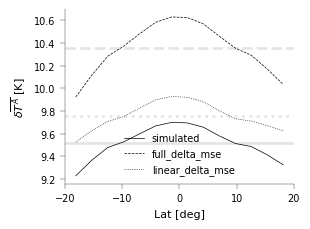

In [48]:
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
linestyles_use = ['-', '--', ':']
for i, key in enumerate(delta_temp_adiabat_mean):
    ax.plot(ds_all[0].lat, delta_temp_adiabat_mean[key], color='k', label=key, linestyle=linestyles_use[i])
    ax.axhline(np.average(delta_temp_adiabat_mean[key], weights=lat_weights, axis=0), color='k', 
               linestyle=linestyles_use[i], lw=2, alpha=0.1)
ax.set_xlim(-lat_max, lat_max)
ax.set_ylabel('$\delta \overline{T^A}$ [K]')
ax.set_xlabel('Lat [deg]')
ax.legend()
plt.tight_layout()

Below, the linear red line captures the broad trend we are after.

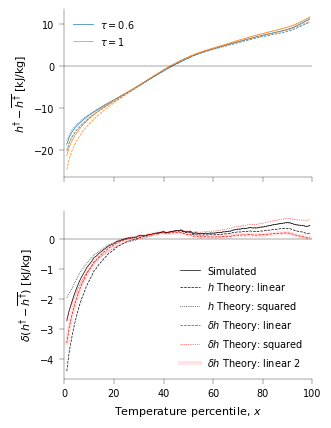

In [50]:
save_mse_anom_fig = False
fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 2*width['one_col']/ar), sharex=True)
for i in range(n_exp):
    ax[0].plot(quantiles_all, 
               np.average(mse_mod_quant3[i] - mse_mod_mean[i][:, np.newaxis], axis=0, weights=lat_weights),
               color=default_colors[i], label=f'$\\tau={tau_lw[i]}$')
    ax[0].plot(quantiles_all, 
               np.average(h_anom_theory['linear'][i], axis=0, weights=lat_weights),
               color=default_colors[i], linestyle='--')
    ax[0].plot(quantiles_all, 
               np.average(h_anom_theory['squared'][i], axis=0, weights=lat_weights),
               color=default_colors[i], linestyle=':')
ax[1].plot(quantiles_all, np.average(delta_h_anom['simulated'], 
                                     axis=0, weights=lat_weights), color='k', label='Simulated')
ax[1].plot(quantiles_all, np.average(np.diff(h_anom_theory['linear'], axis=0)[0], axis=0, weights=lat_weights), 
           color='k', linestyle='--', label='$h$ Theory: linear')
ax[1].plot(quantiles_all, np.average(np.diff(h_anom_theory['squared'], axis=0)[0], axis=0, weights=lat_weights), 
           color='k', linestyle=':', label='$h$ Theory: squared')
ax[1].plot(quantiles_all, np.average(delta_h_anom['linear'], axis=0, weights=lat_weights), 
           color='r', linestyle='--', label='$\delta h$ Theory: linear')
ax[1].plot(quantiles_all, np.average(delta_h_anom['squared'], axis=0, weights=lat_weights), 
           color='r', linestyle=':', label='$\delta h$ Theory: squared')
ax[1].plot(quantiles_all, np.average(delta_h_anom['simple'], axis=0, weights=lat_weights), 
           color='r', label='$\delta h$ Theory: linear 2', lw=3, alpha=0.1)
ax[0].axhline(0, color='k', lw=ax_linewidth)
ax[1].axhline(0, color='k', lw=ax_linewidth)
ax[0].legend()
ax[1].legend()
ax[0].set_ylabel('$h^{\dagger}-\overline{h^{\dagger}}$ [kJ/kg]')
ax[1].set_ylabel('$\delta (h^{\dagger}-\overline{h^{\dagger}})$ [kJ/kg]')
ax[1].set_xlabel(percentile_label)
ax[0].set_xlim(0, 100)

if save_fig or save_mse_anom_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/mse_anom_{region}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

## Breakdown of $\delta (h(x) - \overline{h})$ contributions
Below I show which terms are most important in explaining why $\lambda \neq 1$.

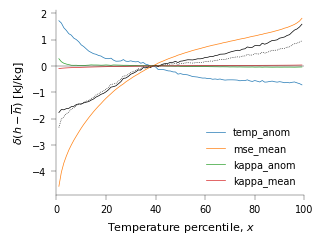

In [16]:
save_mse_anom_theory_decomp_fig = False
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar), sharex=True)
ax.plot(quantiles_all, np.average(delta_h_anom['simulated'], 
                                     axis=0, weights=lat_weights), color='k')
ax.plot(quantiles_all, np.average(delta_h_anom['simple'], axis=0, weights=lat_weights), 
           color='k', linestyle=':')
for i, key in enumerate(delta_h_anom_theory_simple_cont):
    # if ('squared' in key) or (key == 'kappa_anom'):
    #     continue
    ax.plot(quantiles_all, np.average(delta_h_anom_theory_simple_cont[key], axis=0, weights=lat_weights), 
           color=default_colors[i], label=key)
ax.legend()
ax.axhline(0, color='k', lw=ax_linewidth)
ax.set_ylabel('$\delta (h-\overline{h})$ [kJ/kg]')
ax.set_xlabel(percentile_label)
ax.set_xlim(0, 100)

if save_fig or save_mse_anom_theory_decomp_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/mse_anom_theory_decomp{region}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

## Climatological $\Delta T_A$ Breakdown
The variation in the $\delta \overline{h}$ contribution is caused by the variation of $\Delta T^A(x)$ with $x$ in the current climate.
We can decompose this into a WTG and two Convective Equilibrium (CE) terms:
$\Delta T_{WTG}(x) = T_{FT}(x) - \overline{T_{FT}}$
$\Delta T_{CE}(x) = T_{FT}(x) - T^A_{FT}(x)$
$\Delta \overline{T_{CE}} = \overline{T_{FT}} - \overline{T^A_{FT}}$

Putting everything together, we have:
$\Delta T^A(x) = T^A_{FT}(x) - \overline{T^A_{FT}} = \Delta T_{WTG}(x) - \Delta T_{CE}(x) + \Delta \overline{T_{CE}}$

If WTG and CE were both valid in the current climate, then clearly $\Delta T^A(x) = 0$ and the `mse_mean` term in the above plot would be 0.

Equally, we can decompose the change in the anomaly with warming, $\delta \Delta T^A(x)$:
$\delta (\Delta T^A(x)) = \delta (T^A_{FT}(x) - \overline{T^A_{FT}}) = \delta (\Delta T_{WTG}(x)) - \delta(\Delta T_{CE}(x)) + \delta(\Delta \overline{T_{CE}})$

In convective-quasi equilibrium, we would expect $\delta(\Delta T_{CE}(x)) \approx \delta(\Delta \overline{T_{CE}}) \approx 0$. If WTG remained valid, we would expect $\delta (\Delta T_{WTG}(x)) \approx 0$. Together, they would give $\delta (\Delta T^A(x)) \approx 0$.

It seems that WTG is pretty well satisfied, and the main trend comes from the convection part.
If convection becomes more prevalent on all days that are not yet convecting, the climatological $\Delta T_{CE}$ and the change $\delta \Delta T_{CE}$ oppose each other. This happens for small $x$.

If a climate is convecting i.e. $\Delta T_{CE} < 0$ and CAPE increases with warming i.e. $\delta \Delta T_{CE} < 0$ then they reinforce each other. This happens at large $x$.

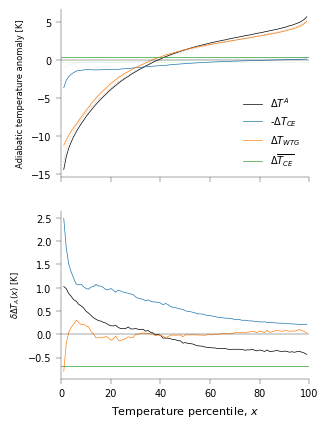

In [17]:
temp_adiabat_anom = temp_adiabat_quant3 - temp_adiabat_mean[:, :, np.newaxis]
temp_wtg_anom = temp_quant3[:, ind_ft] - temp_mean[:, ind_ft][:, :, np.newaxis]
temp_ce_quant_anom = temp_quant3[:, ind_ft] - temp_adiabat_quant3
temp_ce_mean_anom = temp_mean[:, ind_ft] - temp_adiabat_mean

save_temp_adiabat_anom_fig = False
fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 2*width['one_col']/ar), sharex=True)
linestyles_use = ['-', ':']
alpha_use = [1, 0.3]
for i in range(n_exp):
    ax[0].plot(quantiles_all, np.average(temp_adiabat_anom[i], weights=lat_weights, axis=0), color='k', 
               label='$\Delta T^A$' if i==0 else None, linestyle=linestyles_use[i], alpha=alpha_use[i])
    ax[0].plot(quantiles_all, -np.average(temp_ce_quant_anom[i], weights=lat_weights, axis=0), color=default_colors[0], 
               label='-$\Delta T_{CE}$' if i==0 else None, linestyle=linestyles_use[i], alpha=alpha_use[i])
    ax[0].plot(quantiles_all, np.average(temp_wtg_anom[i], weights=lat_weights, axis=0), color=default_colors[1], 
               label='$\Delta T_{WTG}$' if i==0 else None, linestyle=linestyles_use[i], alpha=alpha_use[i])
    ax[0].axhline(np.average(temp_ce_mean_anom[i], weights=lat_weights, axis=0), color=default_colors[2], 
                  label='$\Delta \overline{T_{CE}}$' if i==0 else None, linestyle=linestyles_use[i], alpha=alpha_use[i])
ax[1].plot(quantiles_all, np.average(temp_adiabat_anom[1]-temp_adiabat_anom[0], weights=lat_weights, axis=0), color='k')
ax[1].plot(quantiles_all, -np.average(temp_ce_quant_anom[1]-temp_ce_quant_anom[0], weights=lat_weights, axis=0), color=default_colors[0])
ax[1].plot(quantiles_all, np.average(temp_wtg_anom[1] - temp_wtg_anom[0], weights=lat_weights, axis=0), color=default_colors[1])
ax[1].axhline(np.average(temp_ce_mean_anom[1]-temp_ce_mean_anom[0], weights=lat_weights, axis=0), color=default_colors[2])
ax[0].axhline(0, color='k', lw=ax_linewidth)
ax[1].axhline(0, color='k', lw=ax_linewidth)
ax[0].legend()
ax[1].set_xlabel(percentile_label)
ax[0].set_xlim(0, 100)
ax[0].set_ylabel('Adiabatic temperature anomaly [K]', fontsize=6)
ax[1].set_ylabel('$\delta \Delta T_A(x)$ [K]', fontsize=6)

if save_fig or save_temp_adiabat_anom_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/temp_adiabat_anom_{region}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

Below is basically a repeat of the above, but I include the prefactors in the $\delta (h(x)-\overline{h})$ theory so the actual magnitudes can be compared.

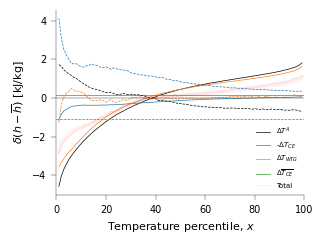

In [18]:
save_mse_anom_decomp_fig = False
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar), sharex=True)
ax.plot(quantiles_all, np.average(delta_h_anom_theory_simple_cont['mse_mean'], weights=lat_weights, axis=0), 
        color='k', label='$\Delta T^A$')
prefactor_use = delta_h_anom_theory_simple_cont['mse_mean'] / temp_adiabat_anom[0]      # [n_lat, n_quant] but same for each quant
ax.plot(quantiles_all, -np.average(prefactor_use * temp_ce_quant_anom[0], weights=lat_weights, axis=0), 
        color=default_colors[0], label='-$\Delta T_{CE}$')
ax.plot(quantiles_all, np.average(prefactor_use * temp_wtg_anom[0], weights=lat_weights, axis=0), 
        color=default_colors[1], label='$\Delta T_{WTG}$')
ax.axhline(np.average(prefactor_use[:, 0] * temp_ce_mean_anom[0], weights=lat_weights, axis=0), color=default_colors[2], 
           label='$\Delta \overline{T_{CE}}$')
prefactor_use = delta_h_anom_theory_simple_prefactors['temp_anom']
ax.plot(quantiles_all, np.average(delta_h_anom_theory_simple_cont['temp_anom'], weights=lat_weights, axis=0), 
        color='k', linestyle='--')
ax.plot(quantiles_all, -np.average(prefactor_use * (temp_ce_quant_anom[1]-temp_ce_quant_anom[0]), weights=lat_weights, axis=0), 
        color=default_colors[0], linestyle='--')
ax.plot(quantiles_all, np.average(prefactor_use * (temp_wtg_anom[1]-temp_wtg_anom[0]), weights=lat_weights, axis=0), 
        color=default_colors[1], linestyle='--')
ax.axhline(np.average(prefactor_use[:, 0] * (temp_ce_mean_anom[1]-temp_ce_mean_anom[0]), weights=lat_weights, axis=0), 
           color=default_colors[2], linestyle='--')
ax.plot(quantiles_all, np.average(delta_h_anom_theory_simple_cont['mse_mean'] + delta_h_anom_theory_simple_cont['temp_anom'],
                                  weights=lat_weights, axis=0), color='r', lw=2, alpha=0.1)
ax.plot(quantiles_all, np.average(delta_h_anom['simple'], weights=lat_weights, axis=0), color='r', alpha=0.1, label='Total')
ax.axhline(0, color='k', lw=ax_linewidth)
ax.legend(fontsize=5)
ax.set_ylabel('$\delta (h-\overline{h})$ [kJ/kg]')
ax.set_xlabel(percentile_label)
ax.set_xlim(0, 100)

if save_fig or save_mse_anom_decomp_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/mse_anom_decomp_{region}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

### Conversion between $\Delta T_{WTG}$ and $\Delta z$
For the extratropics, we know WTG is not valid, so we want to consider geopotential height instead i.e. $\Delta z = z(x) - \overline{z}$. Below, we see how we can convert between the two terms.

The first plot below shows that the assumption that $\delta (T_{FT}(x) - \overline{T_{FT}}) \approx 0$ is better than the approximation  $\delta (z_{FT}(x) - \overline{z_{FT}}) \approx 0$. So may be better to leave in temperature form.

The red line in the bottom plot of the second figure below shows that we can approximate:
$\delta \Delta T_{WTG} \approx \frac{1}{\overline{\kappa}}(\delta \Delta z - \Delta z\frac{\delta \overline{\kappa}}{\overline{\kappa}} - \overline{T_A}\delta \Delta \kappa)$

The exact change given by the dashed line in the same plot includes two more terms and is given by:
$\delta \Delta T_{WTG} \approx \frac{1}{\overline{\kappa}}(\delta \Delta z - \Delta z\frac{\delta \overline{\kappa}}{\overline{\kappa}} - \overline{T_A}\delta \Delta \kappa + \frac{\delta \overline{\kappa}}{\overline{\kappa}}\overline{T_A}\Delta \kappa - \Delta \kappa \delta \overline{T_A})$

In the top figure of this plot, dashed line for $\Delta T_{WTG}$ is given by:
$\Delta T_{WTG} \approx \frac{\Delta z}{\overline{\kappa}} - \frac{\Delta \kappa}{\overline{\kappa}}\overline{T_A}$
The dotted line excludes the second term.

Note that in all these equations, $T_{A}$ should actually be $\overline{T_{FT}}$ in the full derivation, but it turns out not to make hardly any difference, and we use $T_{A}$ elsewhere as we can relate it to $\overline{h}$.

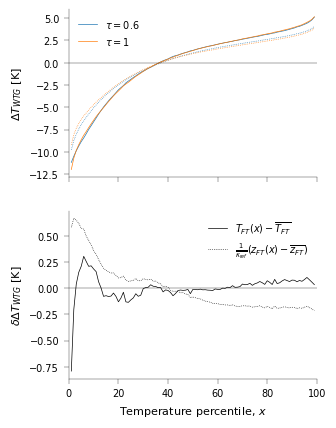

In [19]:
save_wtg_fig = False
fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 2*width['one_col']/ar), sharex=True)
for i in range(n_exp):
    ax[0].plot(quantiles_all, np.average(temp_quant3[i, ind_ft] - temp_mean[i, ind_ft][:, np.newaxis], weights=lat_weights, axis=0),
            color=default_colors[i], label=f'$\\tau={tau_lw[i]}$')
    # Always use kappa_mean[0] in denominator as just want a scaling factor - interested in how z-z_mean changes with warming.
    ax[0].plot(quantiles_all, 
            np.average((z_quant3[i, ind_ft] - z_mean[i, ind_ft][:, np.newaxis])/kappa_mean[0, :, np.newaxis], weights=lat_weights, axis=0), 
            color=default_colors[i], linestyle=':')
ax[1].plot(quantiles_all, np.average(np.diff(temp_quant3[:, ind_ft] - temp_mean[:, ind_ft, :, np.newaxis], axis=0)[0],
                                     weights=lat_weights, axis=0), color='k', label='$T_{FT}(x) - \overline{T_{FT}}$')
ax[1].plot(quantiles_all, 
           np.average(np.diff((z_quant3[:, ind_ft] - z_mean[:, ind_ft, :, np.newaxis])/kappa_mean[0, :, np.newaxis], axis=0)[0], 
                      weights=lat_weights, axis=0), color='k', linestyle=':', 
           label='$\\frac{1}{\overline{\kappa_{ref}}}(z_{FT}(x) - \overline{z_{FT}})$')
# ax[1].plot(quantiles_all, np.average(np.diff(temp_quant3[:, ind_ft] - temp_mean[:, ind_ft, np.newaxis], axis=0)[0],
#                                      weights=lat_weights, axis=0), color='k')
ax[0].axhline(0, color='k', lw=ax_linewidth)
ax[1].axhline(0, color='k', lw=ax_linewidth)
ax[0].set_ylabel('$\Delta T_{WTG}$ [K]')
ax[1].set_ylabel('$\delta \Delta T_{WTG}$ [K]')
ax[0].legend()
ax[1].legend()
ax[1].set_xlabel(percentile_label)
ax[0].set_xlim(0, 100)

if save_fig or save_wtg_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/wtg_{region}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

In [20]:
def get_temp_wtg(z_mean, z_quant, temp_ft_mean, kappa_mean, kappa_quant=None):
    """
    Args:
        z_mean: float
        z_quant: [n_quant]
        temp_ft_mean: float
        kappa_mean: float
        kappa_quant: [n_quant]

    Returns:
        [n_quant]
    """
    z_anom = z_quant - z_mean
    if kappa_quant is None:
        kappa_anom = np.zeros_like(z_anom)
    else:
        kappa_anom = kappa_quant - kappa_mean
    return z_anom/kappa_mean - kappa_anom*temp_ft_mean/kappa_mean

def get_delta_temp_wtg(z_mean, z_quant, temp_ft_mean, kappa_mean, kappa_quant=None, include_delta_temp=True,
                       use_simple_kappa_mean_prefactor=False):
    """
    Args:
        z_mean: [n_exp]
        z_quant: [n_exp, n_quant]
        temp_ft_mean: [n_exp]
        kappa_mean: [n_exp]
        kappa_quant: [n_exp, n_quant]

    Returns:
        [n_quant]
    """
    z_anom = z_quant - z_mean[:, np.newaxis]
    delta_z_anom = z_anom[1] - z_anom[0]
    if kappa_quant is None:
        kappa_anom = np.zeros_like(z_anom)
    else:
        kappa_anom = kappa_quant - kappa_mean[:, np.newaxis]
    delta_kappa_mean = kappa_mean[1] - kappa_mean[0]
    delta_kappa_anom = kappa_anom[1] - kappa_anom[0]
    if include_delta_temp:
        delta_temp_ft_mean = temp_ft_mean[1] - temp_ft_mean[0]
    else:
        delta_temp_ft_mean = np.zeros_like(delta_kappa_mean)
    
    z_anom_prefactor = 1/kappa_mean[0]
    if use_simple_kappa_mean_prefactor:
        kappa_mean_prefactor = -z_anom[0]/kappa_mean[0]**2
    else:
        kappa_mean_prefactor = (kappa_anom[0] * temp_ft_mean[0] - z_anom[0])/kappa_mean[0]**2
    kappa_anom_prefactor = -temp_ft_mean[0]/kappa_mean[0]
    temp_mean_prefactor = -kappa_anom[0]/kappa_mean[0]
    
    return z_anom_prefactor * delta_z_anom + kappa_mean_prefactor * delta_kappa_mean + kappa_anom_prefactor * delta_kappa_anom + \
        temp_mean_prefactor * delta_temp_ft_mean
temp_wtg_anom_from_z = {key: np.zeros((n_exp, n_lat, n_quant_all)) for key in ['no_kappa_anom', 'with_kappa_anom']}
delta_temp_wtg_anom_from_z = {key: np.zeros((n_lat, n_quant_all)) for key in ['no_kappa_anom', 'with_kappa_anom', 
                                                                              'with_kappa_anom_approx1', 'with_kappa_anom_approx2']}

for j in range(n_lat):
    for key in delta_temp_wtg_anom_from_z:
        delta_temp_wtg_anom_from_z[key][j] = get_delta_temp_wtg(z_mean[:, ind_ft, j], z_quant3[:, ind_ft, j], 
                                                                temp_adiabat_mean[:, j], kappa_mean[:, j], 
                                                                kappa_quant3[:, j] if 'with' in key else None, 
                                                                False if 'approx' in key else True, 
                                                                True if '2' in key else False)
        if key not in temp_wtg_anom_from_z:
            continue
        for i in range(n_exp):
            temp_wtg_anom_from_z[key][i, j] = get_temp_wtg(z_mean[i, ind_ft, j], z_quant3[i, ind_ft, j], temp_adiabat_mean[i, j], 
                                                           kappa_mean[i, j], kappa_quant3[i, j] if 'with' in key else None)

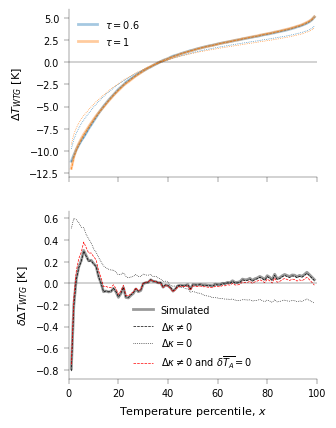

In [21]:
save_wtg_theory_fig = False
fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 2*width['one_col']/ar), sharex=True)
for i in range(n_exp):
    ax[0].plot(quantiles_all, np.average(temp_wtg_anom[i], weights=lat_weights, axis=0), color=default_colors[i], 
               label=f'$\\tau={tau_lw[i]}$', alpha=0.4, lw=2)
    ax[0].plot(quantiles_all, np.average(temp_wtg_anom_from_z['with_kappa_anom'][i], weights=lat_weights, axis=0), color=default_colors[i], 
               linestyle='--')
    ax[0].plot(quantiles_all, np.average(temp_wtg_anom_from_z['no_kappa_anom'][i], weights=lat_weights, axis=0), color=default_colors[i], 
               linestyle=':')
ax[1].plot(quantiles_all, np.average(np.diff(temp_wtg_anom, axis=0)[0], weights=lat_weights, axis=0), color='k', 
           alpha=0.4, lw=2, label='Simulated')
ax[1].plot(quantiles_all, np.average(delta_temp_wtg_anom_from_z['with_kappa_anom'], weights=lat_weights, axis=0),
           color='k', linestyle='--', label='$\Delta \kappa \\neq 0$')
ax[1].plot(quantiles_all, np.average(delta_temp_wtg_anom_from_z['no_kappa_anom'], weights=lat_weights, axis=0),
           color='k', linestyle=':', label='$\Delta \kappa = 0$')
ax[1].plot(quantiles_all, np.average(delta_temp_wtg_anom_from_z['with_kappa_anom_approx2'], weights=lat_weights, axis=0),
           color='r', linestyle='--', label='$\Delta \kappa \\neq 0$ and $\delta \overline{T_A}=0$')
ax[0].legend()
ax[1].legend()
ax[0].axhline(0, color='k', lw=ax_linewidth)
ax[1].axhline(0, color='k', lw=ax_linewidth)
ax[1].set_xlabel(percentile_label)
ax[0].set_xlim(0, 100)
ax[0].set_ylabel('$\Delta T_{WTG}$ [K]')
ax[1].set_ylabel('$\delta \Delta T_{WTG}$ [K]')
if save_fig or save_wtg_theory_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/wtg_theory_{region}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)